Optimal Portfolio Weights (Max Sharpe):
AAPL: 16.64%
NVDA: 0.02%
ORCL: 11.42%
MSFT: 9.59%
WMT: 8.01%
COST: 1.16%
PM: 7.09%
JPM: 0.10%
AXP: 8.73%
VTI: 11.76%
IVV: 10.83%
VOO: 14.65%


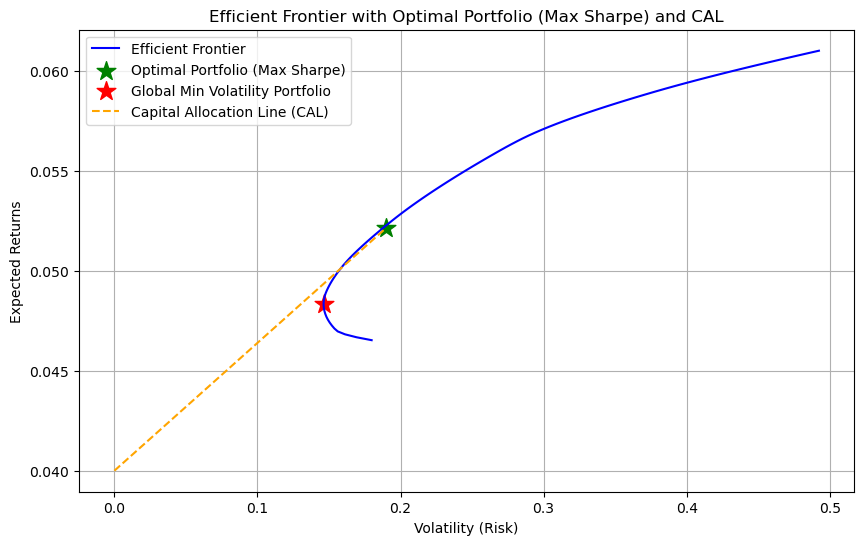

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load the merged data
file_path = 'merged_data.csv'
merged_data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Define tickers
tickers = ["AAPL", "NVDA", "ORCL", "MSFT", "WMT", "COST", "PM", "JPM", "AXP", "VTI", "IVV", "VOO"]

# Step 1: Calculate log returns for each stock (tickers columns)
def calculate_log_returns(prices):
    return np.log(prices / prices.shift(1))

log_returns = merged_data[tickers].apply(calculate_log_returns)

# Step 2: Calculate excess returns (log returns minus RF)
excess_returns = log_returns.sub(merged_data['RF'], axis=0)

# Step 3: Add the Fama-French factors (Mkt-RF, SMB, HML) for regression analysis
factors = merged_data[['Mkt-RF', 'SMB', 'HML']]

# Step 4: Estimate betas for each stock using OLS regression
def estimate_betas(stock_returns, factors):
    X = sm.add_constant(factors)  # Add constant to the regression model
    model = sm.OLS(stock_returns, X, missing='drop').fit()  # Fit OLS model
    return model.params[1:]  # Return betas (excluding the intercept)

betas = pd.DataFrame(columns=['Mkt-RF', 'SMB', 'HML'], index=tickers)

for ticker in tickers:
    betas.loc[ticker] = estimate_betas(excess_returns[ticker], factors)

# Step 5: Calculate the expected return using the Fama-French 3-factor model
def calculate_expected_return(betas, risk_free_rate, factors):
    expected_returns = pd.DataFrame(index=factors.index, columns=betas.index)
    
    for ticker in betas.index:
        if ticker in betas.index:
            expected_returns[ticker] = risk_free_rate + betas.loc[ticker, 'Mkt-RF'] * factors['Mkt-RF'] + \
                                       betas.loc[ticker, 'SMB'] * factors['SMB'] + \
                                       betas.loc[ticker, 'HML'] * factors['HML']
        else:
            expected_returns[ticker] = np.nan

    expected_returns = expected_returns.dropna(how='all')
    return expected_returns

# Assume 4% annual risk-free rate
risk_free_rate = 0.04  

# Calculate the expected returns for each stock
expected_returns = calculate_expected_return(betas, risk_free_rate, merged_data[['Mkt-RF', 'SMB', 'HML']])

# Step 6: Create a DataFrame with Ticker and Mean Expected Returns
mean_expected_returns = expected_returns.mean()
stocks_data = pd.DataFrame({
    'Tickers': mean_expected_returns.index,
    'Mean Expected Return': mean_expected_returns
})

# Step 7: Create the covariance matrix
cov_matrix = log_returns.cov() * 12  # Annualize the covariance matrix

# Step 8: Define a function to calculate the portfolio return
def portfolio_return(weights, er):
    """
    Computes the return on a portfolio from constituent returns and weights
    """
    return np.dot(weights, er)

# Step 9: Define a function to calculate the portfolio volatility
def portfolio_vol(weights, covmat):
    """
    Computes the volatility of a portfolio from the covariance matrix and constituent weights
    """
    return np.sqrt(np.dot(weights.T, np.dot(covmat, weights)))

# Step 10: Generate 1000 portfolios with constraints
# Step 10: Generate 1000 portfolios with constraints
def generate_portfolios(n_portfolios, expected_returns, cov_matrix, max_weight=0.20, min_weight=0.35):
    portfolios = []
    tickers = expected_returns.index
    
    for _ in range(n_portfolios):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)  # Normalize weights so they sum to 1

        # Ensure no stock has more than 20% allocation
        if np.all(weights <= max_weight):
            # Ensure the sum of AAPL, NVDA, ORCL, MSFT is at least 35%
            tech_weights = sum(weights[tickers == x] for x in ['AAPL', 'NVDA', 'ORCL', 'MSFT'])
            if tech_weights >= min_weight:
                portfolio_return_val = portfolio_return(weights, expected_returns)
                portfolio_volatility_val = portfolio_vol(weights, cov_matrix)
                portfolios.append({
                    'Weights': weights,
                    'Return': portfolio_return_val,
                    'Volatility': portfolio_volatility_val,
                    'Sharpe Ratio': (portfolio_return_val - risk_free_rate) / portfolio_volatility_val
                })

    return pd.DataFrame(portfolios)


# Step 11: Generate the portfolios
portfolios = generate_portfolios(1000, mean_expected_returns, cov_matrix)

# Step 12: Find the optimal portfolio (maximizing Sharpe ratio)
optimal_portfolio = portfolios.loc[portfolios['Sharpe Ratio'].idxmax()]

# Step 13: Print the optimal weights for each stock in the optimal portfolio
print("Optimal Portfolio Weights (Max Sharpe):")
optimal_weights = optimal_portfolio['Weights']
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight*100:.2f}%")

# Step 14: Calculate GMV portfolio weights (minimize volatility without return constraint)
def gmv(cov_matrix):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = len(cov_matrix)
    ones = np.ones(n)
    
    # Minimize volatility (no return constraint)
    result = minimize(portfolio_vol, np.repeat(1/n, n), args=(cov_matrix,), method='SLSQP', 
                      bounds=((0, 1),) * n, constraints={'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    return result.x

# Get GMV portfolio weights
gmv_weights = gmv(cov_matrix)

# Step 15: Generate the Efficient Frontier
def efficient_frontier(n_points, expected_returns, cov_matrix):
    target_returns = np.linspace(expected_returns.min(), expected_returns.max(), n_points)
    portfolios = []

    for target_return in target_returns:
        weights = minimize_vol(target_return, expected_returns, cov_matrix)
        ret = portfolio_return(weights, expected_returns)
        vol = portfolio_vol(weights, cov_matrix)
        portfolios.append([ret, vol])
    
    return pd.DataFrame(portfolios, columns=['Returns', 'Volatility'])

# Step 16: Define a function to minimize volatility for a given target return
def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n  # an N-tuple of 2-tuples!
    
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    return_is_target = {'type': 'eq', 'args': (er,), 'fun': lambda weights, er: target_return - portfolio_return(weights, er)}

    # Minimize volatility
    result = minimize(portfolio_vol, init_guess, args=(cov,), method='SLSQP', bounds=bounds,
                      constraints=(weights_sum_to_1, return_is_target))
    
    return result.x

# Step 17: Generate the Efficient Frontier
n_points = 100  # Number of points for the frontier
ef = efficient_frontier(n_points, mean_expected_returns, cov_matrix)

# Step 18: Plot the Efficient Frontier, Optimal Portfolio, and Capital Allocation Line (CAL)
plt.figure(figsize=(10, 6))
plt.plot(ef['Volatility'], ef['Returns'], label='Efficient Frontier', color='b')

# Plot the Optimal Portfolio (Max Sharpe)
optimal_return = portfolio_return(optimal_portfolio['Weights'], mean_expected_returns)
optimal_vol = portfolio_vol(optimal_portfolio['Weights'], cov_matrix)
plt.scatter(optimal_vol, optimal_return, color='green', marker='*', s=200, label='Optimal Portfolio (Max Sharpe)')

# Plot the GMV Portfolio
gmv_return = portfolio_return(gmv_weights, mean_expected_returns)
gmv_vol = portfolio_vol(gmv_weights, cov_matrix)
plt.scatter(gmv_vol, gmv_return, color='red', marker='*', s=200, label='Global Min Volatility Portfolio')

# Plot the Capital Allocation Line (CAL) from Risk-Free Asset to Optimal Portfolio (Max Sharpe)
cal_x = np.linspace(0, optimal_vol, 100)  # X-axis for the CAL (volatility from 0 to Optimal Portfolio volatility)
cal_y = risk_free_rate + (optimal_return - risk_free_rate) / optimal_vol * cal_x  # CAL formula

plt.plot(cal_x, cal_y, linestyle='--', color='orange', label='Capital Allocation Line (CAL)')

# Formatting the plot
plt.title('Efficient Frontier with Optimal Portfolio (Max Sharpe) and CAL')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Returns')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
pip install torch


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
